# LSTM Batch Visualization script

In [155]:
%matplotlib inline
from copy import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from IPython.core.display import HTML

sns.set_context('poster')
sns.set_style("whitegrid")
sns.light_palette("navy", as_cmap=True)

In [156]:
keywords = ['cellstates', 'probabilities', 'sample']
mapping = {1:'(',
           2:')',
           3:']',
           4:'['}

In [157]:
def parse_paren(some_string, some_palette):
    color_codes = {i:v for i,v in enumerate(some_palette.as_hex())}
    html_parse = '<div style="font-size:18pt; line-height: 24px">'
    depth = 0
    for c in some_string:
        if c == "(" or c == "[":
            #print " "*depth,"("
            html_parse += '<span style="color:{0};">{1}</span>'.format(color_codes[depth], c)
            depth+=1
            
        else:
            if depth > 0:
                depth-=1
            html_parse += '<span style="color:{0};">{1}</span>'.format(color_codes[depth], c)

            #print " "*depth,")"
    html_parse += "</div>"
    return HTML(html_parse)

In [158]:
def get_depth_for_samples(some_text):
    depth = 0
    depth_array = []
    for c in some_text:
        if c == "(" or c == "[":
            depth+=1
        elif depth > 0:
            depth-=1
        depth_array.append(depth)
    
    return depth_array

In [159]:
def get_correct_array(some_text):
    depth_array = []
    correct_array = []
    for c in some_text:
        if c == "(" or c == "[":
            depth_array.append(c)
            correct_array.append('g')
        else:
            try:
                curr_open = depth_array.pop()
                if (curr_open == "(" and c == ")") or (curr_open == "[" and c == "]"):
                    correct_array.append('g')
                else:
                    correct_array.append('r')
            except:
                correct_array.append('r')
    return correct_array
#str(get_correct_array(sample_text))

In [160]:
# plot to visualize excitement / importance of cellstate character by character
def plotNeuronExcitement(ax, cellstates, useAbs=True):
    # K is number of latent factors used by the cell state
    K = curr_cellstates.shape[1]
    # N is the number of neurons
    N = len(cellstates)
    
    # different excitement metrics (each metric should return a value between 0 and 1 to allow comparison for different K)
    # input is the tanh(cellstate) vector for a node
    def absmetric(tanhC):
        return 0.5 * np.sum(np.abs(tanhC)) / tanhC.shape[0]
    def totmetric(tanhC):
        return (tanhC.shape[0] + np.sum(tanhC)) / (2 * tanhC.shape[0])

    for i in xrange(N):
        ax.plot(np.arange(cellstates[i].shape[0]), np.apply_along_axis(absmetric if useAbs == True else totmetric, 1, cellstates[i]), label='neuron %d' % (i+1))
    plt.legend(loc='best')

    # format ticks to input
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    plt.xticks([i+.5 for i in xrange(50-1)])
    # Customize minor tick labels
    ax.xaxis.set_minor_locator(ticker.FixedLocator([i for i in xrange(50-1)]))
    ax.xaxis.set_minor_formatter(ticker.FixedFormatter([mapping[i] for i in list(curr_sample.s)[:-1]]))
    


In [161]:
# heatmap plot for individual cellstate factors for each neuron
def plotNeuronHeatmap(ax, cellstates, useAbs=True):
    # K is number of latent factors used by the cell state
    K = curr_cellstates.shape[1]
    # N is the number of neurons
    N = len(cellstates)
    
    cmaps = [plt.cm.Blues, plt.cm.Reds, plt.cm.Greens, plt.cm.Purples]
    for i in xrange(N):
        x = np.arange(cellstates[i].shape[0] + 1)
        y = np.arange(cellstates[i].shape[1] + 1) + (N - i - 1) * K
        X, Y = np.meshgrid(x, y)

        ax.pcolor(X, Y, np.abs(cellstates[i].T) if useAbs == True else cellstates[i].T, cmap=cmaps[i % 4], alpha=0.8, edgecolors='w', lw=2)

    #  get equal axis ratio for better visually compelling results
    ax.set_aspect('equal')

    ax.set_xlim([0, cellstates[0].shape[0]])
    ax.set_ylim([0, N * cellstates[0].shape[1]])

    # format ticks to input
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
    plt.xticks([i + .5 for i in xrange(cellstates[0].shape[0])])
    plt.yticks([((N - i - 1) + .5) * K for i in xrange(N)])
    
    # Customize minor tick labels
    ax.xaxis.set_minor_locator(ticker.FixedLocator([i+0.5 for i in xrange(cellstates[0].shape[0])]))
    ax.xaxis.set_minor_formatter(ticker.FixedFormatter([mapping[i] for i in list(curr_sample.s)[:-1]]))
    ax.yaxis.set_minor_locator(ticker.FixedLocator([((N - i - 1) + .5) * K for i in xrange(N)]))
    ax.yaxis.set_minor_formatter(ticker.FixedFormatter(['neuron %d ' % (i+1) for i in xrange(N)]))
    
# remove spines
def removeSpines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return ax


In [162]:
# create dir if it does not exists already
def create_dir(path):
    if not os.path.exists(path):
        try:
            os.makedirs(path)
        except OSError as error:
            if error.errno != errno.EEXIST:
                raise
    return path

### Batch plotting code

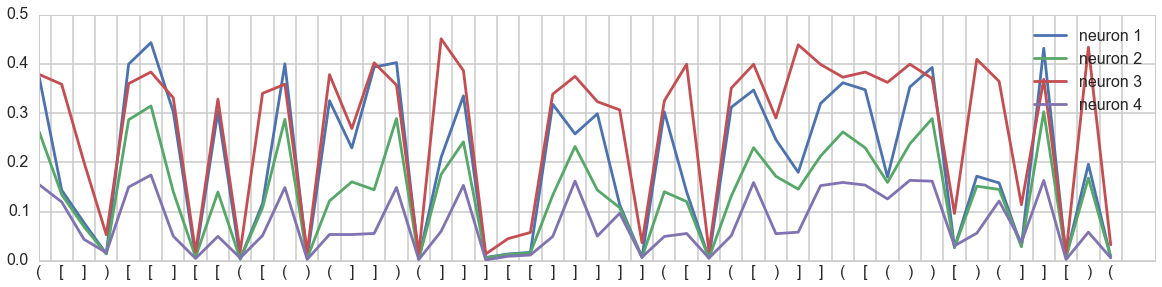

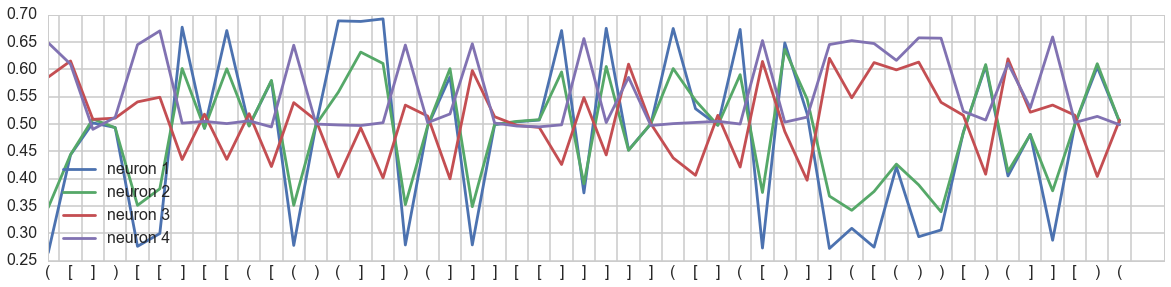

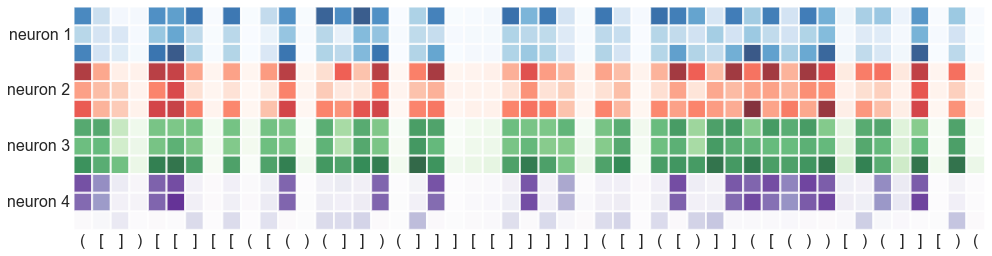

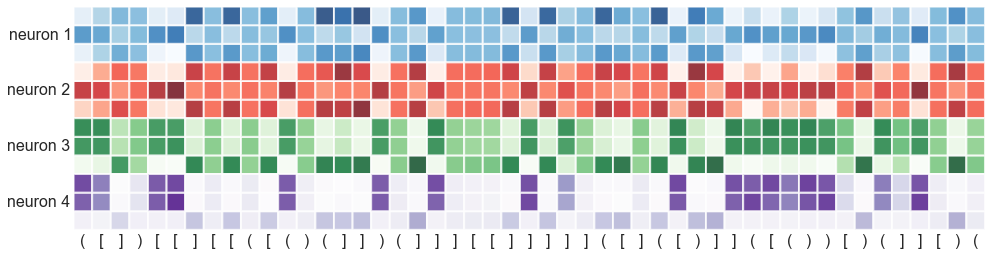

In [165]:
# specify here files to compute figures for
check_files = [f[10:] for f in os.listdir("cv") if 'cellstates' in f]
#prototyping
check_files = ['_lm_test3_epoch41.21_1.0969.txt']

output_path = create_dir('images')
dpi = 120


#need to modify for > 1 sample
for j in xrange(len(check_files)):
    curr_cellstates = pd.read_csv('cellstates'+check_files[j], header=None)
    curr_probs = pd.read_csv('probabilities'+check_files[j], header=None)
    curr_probs.columns = ['1','2','3','4']
    curr_probs = curr_probs.apply(lambda x: np.exp(x))
    curr_sample = pd.read_csv('sample'+check_files[j], header=None).T
    curr_sample.columns = ['s']

    sample_text = ''.join([mapping[i] for i in list(curr_sample.s)[:-1]])

    ## plot colored language sample
    #pal5 = sns.color_palette("RdBu_r", 6)
    #parse_paren(sample_text, pal5)

    # split for the 4 neurons
    # it holds curr_cellstates.shape[0]/4 == curr_probs.shape[0]-1 (note the -1 due to first input character!)
    cellstates = {}
    for i in xrange(N):
        cellstates[i] = np.array(curr_cellstates.iloc[curr_cellstates.shape[0] / 4 * i:curr_cellstates.shape[0] / 4 * (i+1)])

    # do batch plotting and saving

    # plot excitement
    fig = plt.figure(figsize=(20,15))
    ax = plt.subplot(312)
    plt.rcParams["figure.figsize"] = [20, 4]
    plotNeuronExcitement(ax, cellstates, useAbs=True)
    #removeSpines(ax)
    plt.savefig(os.path.join(output_path, 'abs_excitement'+check_files[j]+'.png'), dpi=dpi)

    fig = plt.figure(figsize=(20,15))
    ax = plt.subplot(312)
    plt.rcParams["figure.figsize"] = [20, 4]
    plotNeuronExcitement(ax, cellstates, useAbs=False)
    #removeSpines(ax)
    plt.savefig(os.path.join(output_path, 'tot_excitement'+check_files[j]+'.png'), dpi=dpi)

    # plot heatmap
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [20, 4]
    plotNeuronHeatmap(ax, cellstates, useAbs=True)
    removeSpines(ax)
    plt.savefig(os.path.join(output_path, 'abs_cstate'+check_files[j]+'.png'), dpi=dpi)

    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [20, 4]
    plotNeuronHeatmap(ax, cellstates, useAbs=False)
    removeSpines(ax)
    plt.savefig(os.path.join(output_path, 'tot_cstate'+check_files[j]+'.png'), dpi=dpi)

49
49


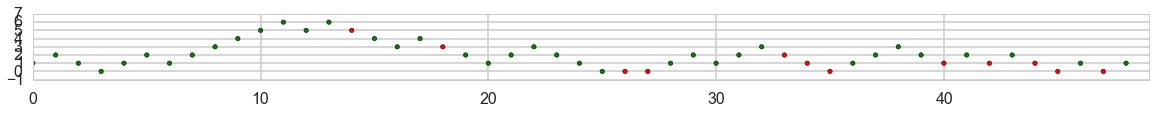

In [136]:
# plt.figure(figsize=(20,4))
# ax1 = plt.subplot(312)
# depths_sample = get_depth_for_samples(sample_text)
# print len(depths_sample)
# correct_sample = get_correct_array(sample_text)
# x_vals = np.linspace(0,48,49)
# print len(x_vals)
# plt.scatter(x_vals, depths_sample, c=correct_sample)
# plt.xlim([0,49])
# plt.show()

# x = np.array(curr_probs[['2','4']]).T#.reshape(4,50)
# fig = plt.figure(figsize=(20,6))

# ax1 = plt.subplot(312)
# depths_sample = get_depth_for_samples(sample_text)
# correct_sample = get_correct_array(sample_text)
# x_vals = np.linspace(0,48,49)
# plt.scatter(x_vals, depths_sample, c=correct_sample)

# ax = plt.subplot(313, sharex=ax1)

# colors = sns.light_palette((315, 80, 50), input="husl", as_cmap=True)#sns.diverging_palette(10, 220, sep=80, n=7, as_cmap=True)
# plt.imshow(x, interpolation='nearest', aspect=2, cmap=colors)
# plt.xticks([i+.5 for i in xrange(50)])
# plt.yticks([.5,1.5]) #
# #plt.colorbar()

# labels = [item.get_text() for item in ax.get_xticklabels()]
# labels[1] = 'Testing'

# plt.grid(b=True, which='both', color='0.65',linestyle='')

# import matplotlib.ticker as ticker

# # a is an axes object, from figure.get_axes()

# # Hide major tick labels
# ax.xaxis.set_major_formatter(ticker.NullFormatter())
# ax.yaxis.set_major_formatter(ticker.NullFormatter())

# # Customize minor tick labels
# ax.xaxis.set_minor_locator(ticker.FixedLocator([i for i in xrange(50)]))
# ax.xaxis.set_minor_formatter(ticker.FixedFormatter([mapping[i] for i in list(curr_sample.s)[:-1]]))

# ax.yaxis.set_minor_locator(ticker.FixedLocator([0,1]))
# ax.yaxis.set_minor_formatter(ticker.FixedFormatter([')',']']))

# figtitle = 'What does the LSTM predict given the depth and generated string?' 
# t = fig.text(.5, .65, figtitle,  
#                horizontalalignment='center',
#                fontsize=16) 
# plt.show()